In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Cleaning, Preprocessing and Analysis

## 1)Data Cleaning

### Check for 'Null' or 'NaN'

In [56]:
csv_dir = "./data"

# 1. Load all CSVs from the directory and concatenate
dfs = []
for fname in os.listdir(csv_dir):
    if fname.endswith(".csv"):
        path = os.path.join(csv_dir, fname)
        dfs.append(pd.read_csv(path))

df = pd.concat(dfs, ignore_index=True)

print("Columns in raw data:", df.columns.tolist())

# 2. Define attributes (all columns)
attributes = list(df.columns)

# 3. Convert data columns to numeric
for col in attributes:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 4. Global sanity checks (only on attribute columns)
n_nulls = df[attributes].isnull().sum().sum()
n_nans = df[attributes].isna().sum().sum()
non_numeric_cols = df[attributes].select_dtypes(exclude=["number"]).columns.tolist()

print(f"Total Nulls found: {n_nulls}")
print(f"Total NaNs found:  {n_nans}")
print(f"Non-numeric columns: {non_numeric_cols}")

# 5. Per-column summary
print("\nPer-column nulls/NaNs:")
print(df[attributes].isna().sum())

Columns in raw data: ['YYYY', 'MM', 'DD', 'DOY', '2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'prec', 'volsw_123', 'volsw_4']
Total Nulls found: 0
Total NaNs found:  0
Non-numeric columns: []

Per-column nulls/NaNs:
YYYY                       0
MM                         0
DD                         0
DOY                        0
2m_temp_max                0
2m_temp_mean               0
2m_temp_min                0
2m_dp_temp_max             0
2m_dp_temp_mean            0
2m_dp_temp_min             0
10m_wind_u                 0
10m_wind_v                 0
fcst_alb                   0
lai_high_veg               0
lai_low_veg                0
swe                        0
surf_net_solar_rad_max     0
surf_net_solar_rad_mean  

### Checking for the max/min

In [57]:
attr_names = attributes
nums = df[attr_names]

print(f"{'Attribute':25} {'Min':>10} {'Max':>10}")
print("-" * 50)

for col in attr_names:
    vals = nums[col]
    print(f"{col:25} {vals.min():10.3f} {vals.max():10.3f}")


Attribute                        Min        Max
--------------------------------------------------
YYYY                        1981.000   2019.000
MM                             1.000     12.000
DD                             1.000     31.000
DOY                            1.000    366.000
2m_temp_max                  -24.900     36.400
2m_temp_mean                 -30.200     29.600
2m_temp_min                  -38.800     24.200
2m_dp_temp_max               -34.800     26.400
2m_dp_temp_mean              -37.300     21.000
2m_dp_temp_min               -42.600     19.700
10m_wind_u                    -6.500      8.300
10m_wind_v                    -7.800      7.700
fcst_alb                       0.070      0.810
lai_high_veg                   0.800      5.000
lai_low_veg                    0.300      3.800
swe                            0.000   2995.380
surf_net_solar_rad_max         4.000    836.000
surf_net_solar_rad_mean        1.000    309.000
surf_net_therm_rad_max       -17.000 

### Checking negative/zero/positive values

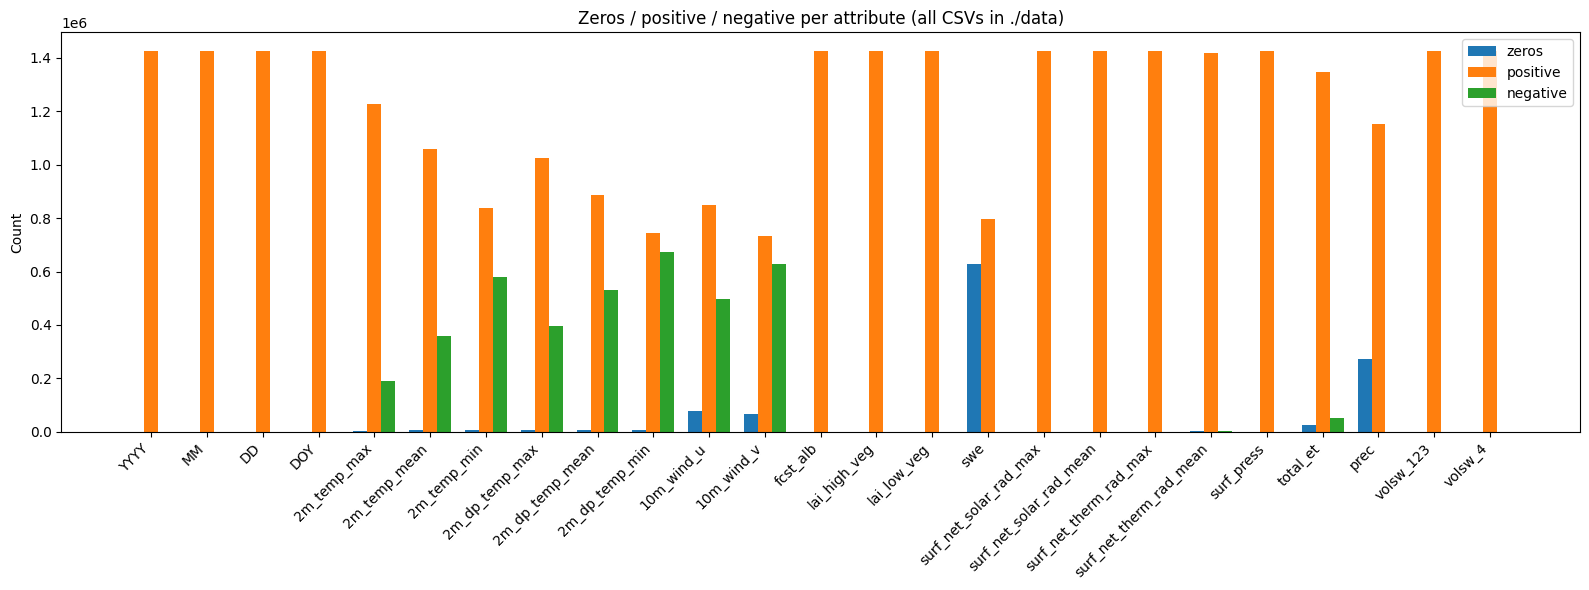

In [60]:
csv_dir = "./data"

# Load and concatenate all CSVs
dfs = []
for fname in os.listdir(csv_dir):
    if fname.endswith(".csv"):
        path = os.path.join(csv_dir, fname)
        dfs.append(pd.read_csv(path))

df = pd.concat(dfs, ignore_index=True)

zero = (nums == 0).sum()
pos  = (nums > 0).sum()
neg  = (nums < 0).sum()

x = np.arange(len(attributes))
w = 0.25

plt.figure(figsize=(16, 6))
plt.bar(x - w, zero.values, w, label="zeros")
plt.bar(x,     pos.values,  w, label="positive")
plt.bar(x + w, neg.values,  w, label="negative")

plt.xticks(x, attributes, rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Zeros / positive / negative per attribute (all CSVs in ./data)")
plt.legend()
plt.tight_layout()
plt.show()

looks all good except of total_et, lets see if the negative values arise just from one dataframe, or in more

### Checking for negative/zero/positive values for 'total_et' for the individual loaded location files

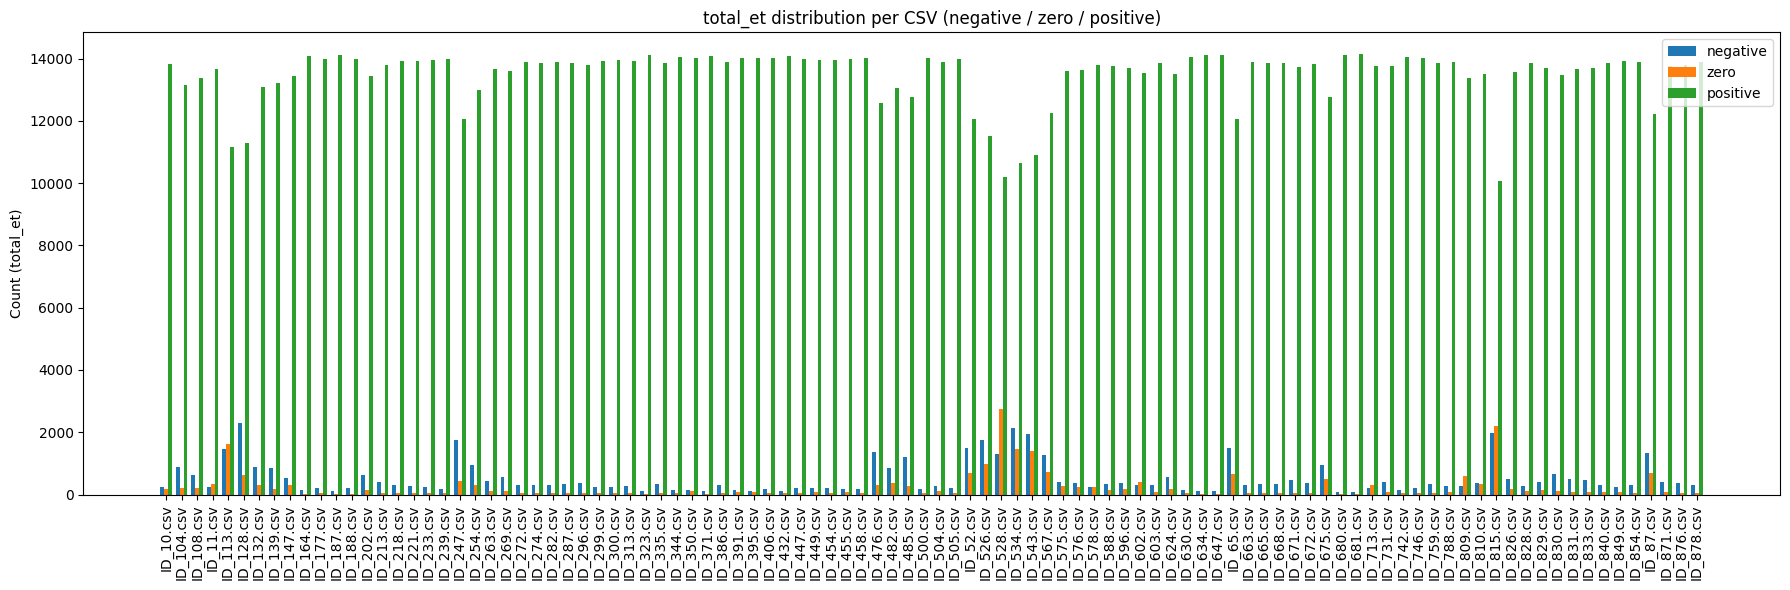

In [61]:
csv_dir = "./data"

df_labels = []
neg_counts = []
zero_counts = []
pos_counts = []

# Loop over all CSVs in ./data
for fname in sorted(os.listdir(csv_dir)):
    if not fname.endswith(".csv"):
        continue

    path = os.path.join(csv_dir, fname)
    df = pd.read_csv(path)

    # Make sure total_et is numeric
    te = pd.to_numeric(df["total_et"], errors="coerce")

    df_labels.append(fname)  # or fname.replace(".csv", "") if you prefer
    neg_counts.append((te < 0).sum())
    zero_counts.append((te == 0).sum())
    pos_counts.append((te > 0).sum())

# Convert to numpy arrays
neg_counts = np.array(neg_counts)
zero_counts = np.array(zero_counts)
pos_counts = np.array(pos_counts)

# Plot: three bars (neg/zero/pos) per CSV
x = np.arange(len(df_labels))
width = 0.25

plt.figure(figsize=(18, 6))
plt.bar(x - width, neg_counts,  width, label="negative")
plt.bar(x,         zero_counts, width, label="zero")
plt.bar(x + width, pos_counts,  width, label="positive")

plt.ylabel("Count (total_et)")
plt.title("total_et distribution per CSV (negative / zero / positive)")
plt.xticks(x, df_labels, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

Here is a question mark:
Physically, ET should be ≥ 0 (it’s a water flux leaving the surface). Negative values mean either:
different sign convention (e.g. positive = downward flux, negative = upward), or the variable is actually net surface flux mislabeled as “ET”, or errors in the data / preprocessing.

Zeros themselves (no ET on some days) are not crazy — e.g. frozen soil, snow cover, very cold/dry air — but the many negative values are suspicious if the variable is truly “total evapotranspiration (mm)”.

## 2) Data Analysis

### Average Attribute Correlation across all 100 locations

Average correlation matrix from 100 CSVs


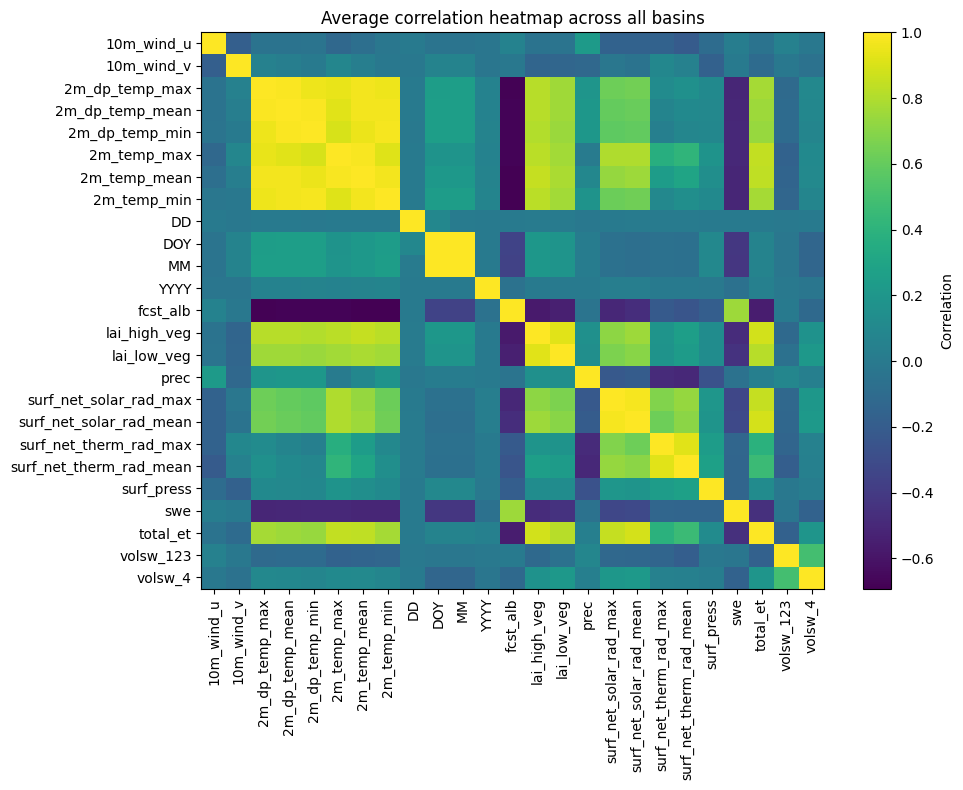

In [65]:
csv_dir = "./data"

corr_matrices = []
valid_files = []

for fname in os.listdir(csv_dir):
    if not fname.endswith(".csv"):
        continue

    path = os.path.join(csv_dir, fname)
    df = pd.read_csv(path)

    # numeric columns only
    df_numeric = df.select_dtypes(include="number")

    if df_numeric.shape[1] < 2:
        continue

    corr = df_numeric.corr()
    corr_matrices.append(corr)
    valid_files.append(fname)

if not corr_matrices:
    print("No valid CSVs found for correlation.")
else:
    # union of all columns
    all_cols = sorted(set().union(*[c.index for c in corr_matrices]))

    # reindex each corr matrix to same shape
    corr_reindexed = [
        c.reindex(index=all_cols, columns=all_cols)
        for c in corr_matrices
    ]

    # average, ignoring NaNs
    avg_corr = np.nanmean(np.stack(corr_reindexed), axis=0)
    avg_corr_df = pd.DataFrame(avg_corr, index=all_cols, columns=all_cols)

    print(f"Average correlation matrix from {len(valid_files)} CSVs")

    # ---------- Heatmap ----------
    plt.figure(figsize=(10, 8))
    im = plt.imshow(avg_corr_df.values, aspect='auto')
    plt.colorbar(im, label="Correlation")

    plt.xticks(ticks=np.arange(len(all_cols)), labels=all_cols, rotation=90)
    plt.yticks(ticks=np.arange(len(all_cols)), labels=all_cols)

    plt.title("Average correlation heatmap across all basins")
    plt.tight_layout()
    plt.show()

## 3) Data Preprocessing for Prediction

### Add target colums to csv file for predicting 'prec' 1, 3, 7 day(s) ahead

In [63]:
input_dir = "./data"
output_dir = "./data_for_prediction"

os.makedirs(output_dir, exist_ok=True)

target_cols = ["prec_1d_ahead", "prec_3d_ahead", "prec_7d_ahead"]

files_with_missing = []

for fname in os.listdir(input_dir):
    if not fname.endswith(".csv"):
        continue

    in_path = os.path.join(input_dir, fname)
    out_path = os.path.join(output_dir, fname)

    df = pd.read_csv(in_path)

    # Ensure prec is numeric
    df["prec"] = pd.to_numeric(df["prec"], errors="coerce")

    # Sort by date if possible
    if {"YYYY", "MM", "DD"}.issubset(df.columns):
        df = df.sort_values(["YYYY", "MM", "DD"]).reset_index(drop=True)

    # Create future target columns per basin using shift
    df["prec_1d_ahead"] = df["prec"].shift(-1)
    df["prec_3d_ahead"] = df["prec"].shift(-3)
    df["prec_7d_ahead"] = df["prec"].shift(-7)

    # Forward-fill missing targets (e.g. at the end after shift)
    df[target_cols] = df[target_cols].ffill()

    # Sanity check: only on target columns
    n_missing = df[target_cols].isna().sum().sum()
    if n_missing > 0:
        files_with_missing.append((fname, int(n_missing)))

    # Save processed file
    df.to_csv(out_path, index=False)

# ---- Single summary message at the end ----
if files_with_missing:
    print("⚠️ Some files still have NaNs in target columns:")
    for fname, n in files_with_missing:
        print(f"  - {fname}: {n} missing values in {target_cols}")
else:
    print("✅ All files processed: no NaNs in target columns", target_cols)


✅ All files processed: no NaNs in target columns ['prec_1d_ahead', 'prec_3d_ahead', 'prec_7d_ahead']
